<a href="https://colab.research.google.com/github/dentonfreeman/Complete-Python-3-Bootcamp/blob/master/Copy_of_fantasy_pros_scraping_to_make_players_tiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The script does the following: 

1. Scrapes Fantasy Pros rankings
2. Uses a clustering algo to group players
  -  you can start to get a sense of who's on a similar playing level based on the aggregated rankings
3. Display players by their tier in an interactive visualization
  - See where players rank, which group they are in, and general ranking for the defense (i.e., the bigger the circle next to a player's name, the worse the defense ranking)


In [ ]:
from bs4 import BeautifulSoup
import requests 
import re

import pandas as pd
from itertools import chain

from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)



import plotly.graph_objs as go

import numpy as np

import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def select_position(string):

    if string == 'qb':
        positions = 'qb'

        URL  = f'https://www.fantasypros.com/nfl/rankings/{positions}'

    if string == 'rb':
        positions = 'rb'
        URL  = f'https://www.fantasypros.com/nfl/rankings/half-point-ppr-{positions}'
      
    if string == 'wr':
        positions = 'wr'
        URL  = f'https://www.fantasypros.com/nfl/rankings/half-point-ppr-{positions}'
    
    if string == 'te':
        positions = 'te'
        URL  = f'https://www.fantasypros.com/nfl/rankings/half-point-ppr-{positions}'

    if string == 'flex':
        positions = 'flex'
        URL  = f'https://www.fantasypros.com/nfl/rankings/half-point-ppr-{positions}'
        

    r = requests.get(URL) 
    soup = BeautifulSoup(r.content, 'html5lib')   
    return soup
    


In [ ]:
def sentiment_scorer(text):
    score = blob(text).sentiment
    return score[0]
  


In [ ]:

def scrape_fantasypros(soup, position):
    soup = soup 
    all_rows = []
    count = 0
    section = soup.find_all('table')
    col_names = ['rank', 'name', 'opp', 'd_rank',  'best', 'worst', 'avg', 'std'] #, 'projected_points']
    for elem in section:
        wrappers = elem.find_all('tr')
        for sub_elem in wrappers:
            info = sub_elem.find_all('td')
            try:
                row = []
                another_soup = BeautifulSoup(str(info),'lxml')
                rank = another_soup.find(class_= 'sticky-cell sticky-cell-one').get_text()
                name = another_soup.find(class_= 'full-name').get_text()
                opp = another_soup.find(class_= 'opp-cell').get_text()
                defense = str(another_soup.find(class_= 'opp-cell'))
                if 'easy' in defense:
                    defense = 3
                elif 'hard' in defense:
                    defense = 1
                else:
                    defense = 2

                # if another_soup.find(class_= 'opp-cell hard').get_text() is not None :
                #     opp = another_soup.find(class_= 'opp-cell hard').get_text()
                #     idk = another_soup.find(class_= 'opp-cell hard')
                #     print(idk)
                #     defense = .25
                # elif another_soup.find(class_= 'opp-cell easy').get_text() is not None :
                #     opp = another_soup.find(class_= 'opp-cell easy').get_text()
                #     defense = .75
                # else: 
                #     opp = another_soup.find(class_= 'opp-cell').get_text()
                #     defense = .50
                
                for i in info:
                    if position != 'flex':
                    #opp = info[-5].get_text()
                        best = int(info[4].get_text())
                        worst = int(info[5].get_text())
                        avg = float(info[6].get_text())
                        std = float(info[7].get_text())
                    else:
                        best = int(info[5].get_text())
                        worst = int(info[6].get_text())
                        avg = float(info[7].get_text())
                        std = float(info[8].get_text())
                     
                    #projected_points = float(info[8].get_text())
                row.append([rank, name, opp, defense, best, worst, avg, std ])#, projected_points])
                all_rows.append(row)
            except:
                pass

    data = (list(chain(*all_rows)))
    df = pd.DataFrame(data , columns= col_names)

    return df

  
def find_and_sort_clusters(dataframe, num_obs):
    num_obs = num_obs
    d2 = dataframe.copy()
    d2 = d2.iloc[:num_obs, :]

    X = d2[['rank','d_rank', 'best', 'worst', 'avg', 'std']]#, 'projected_points']]

    data_scaled = normalize(X)
    data_scaled = pd.DataFrame(data_scaled, columns=X.columns)
    data_scaled.head()

    dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
    plt.axhline(y=.3, color='r', linestyle='--')

    d = [ np.sum(i) for i in dend['dcoord']]
    count = len([i for i in d if i >=.4])

    hc = AgglomerativeClustering(n_clusters=count, affinity='euclidean', linkage='ward')
    labels = hc.fit_predict(X) ; labels

    print(f'Found {count} tiers of players')
    d2['labels'] = labels

    clusters = d2.groupby('labels' , as_index= False).mean()
    clusters.sort_values('avg' , inplace = True); clusters
    orders = list(range(1, len(clusters)+1))
    clusters['order'] = orders
    kv = dict(list(zip(clusters.labels, clusters.order)))
    d2['tier'] = d2['labels'].apply(lambda x : kv.get(x))
    d2.sort_values('tier' , inplace = True) 
    return d2 

In [ ]:
def configure_plotly_browser_state():
  import IPython as iplot
  display(iplot.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


def plot_data(df , position):

    if position == 'qb':
        w=1000
        h=1000
    elif position == 'flex':
        w = 1500
        h = 2100
    elif position == 'rb' or 'wr':
        w=900
        h=1400
    else:
        w=1000
        h=1000

    configure_plotly_browser_state()

    df['tier'] = df['tier'].apply(lambda x: str(x))

    fig = px.scatter(df, x='avg', y='rank', text="name"  ,  color = 'tier', 
                    error_x = 'std', size = 'd_rank', 
                     width=w, height=h, opacity = .7  )
    fig.update_traces(textposition='middle right', 
                      textfont=dict(
        family="sans serif",
        size=14
    ))


    fig.update_layout(
        autosize=True,
        
        xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Average Expert Rank",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="FantasyPros Consensus Rank",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
        )

    
    fig.update_layout(showlegend=False)
    fig.update_layout(showlegend=True)


    fig.update_yaxes(automargin=True , autorange = "reversed")
    fig.update_xaxes(automargin=True )

    yaxis = dict(autorange = 'reversed')


    iplot(fig)
    plotly.offline.plot(fig, filename='test.html') 

def model(position):
    if position == 'qb':
        num_players = 25
    elif position == 'rb' or 'wr':
        num_players =60
    elif position == 'flex':
        num_players = 100
    elif position == 'te':
        num_players = 25
    else:
        position = position
        num_players = 30
    t = select_position(position) ;t
    df = scrape_fantasypros(t, position); df.head()
    df = find_and_sort_clusters(df, num_players)
    plot_data(df , position)
    return df




Found 7 tiers of players


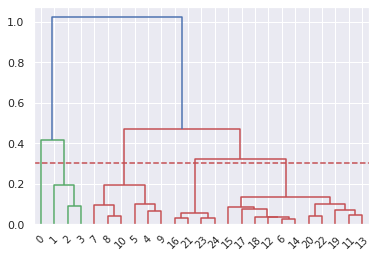

In [ ]:
qb= model('qb')

Found 15 tiers of players


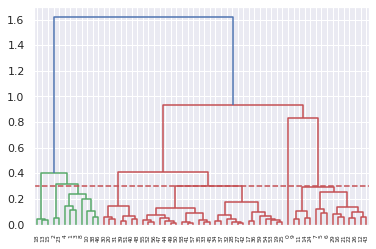

In [ ]:
wr = model('wr')


Found 12 tiers of players


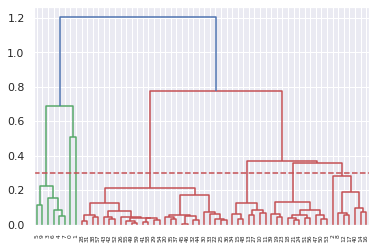

In [ ]:
te = model('te')

Found 12 tiers of players


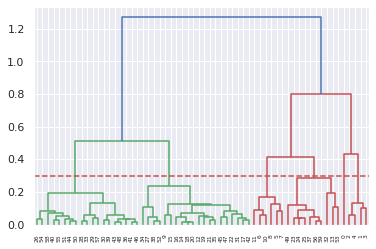

In [ ]:
rb =model('rb')


Found 15 tiers of players


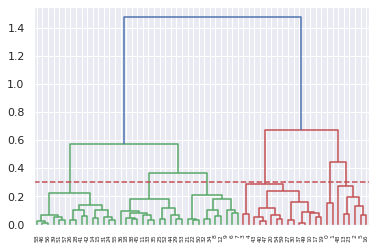

In [ ]:
flex  = model('flex')